# Brain Tumor Detection Using a Convolutional Neural Network

**About the Brain MRI Images dataset:**<br>
The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous and the folder no contains 98 Brain MRI Images that are non-tumorous. You can find it [here](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection).

## Import Necessary Modules

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense ,Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

## Data Preparation & Preprocessing

In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain. You can read more about it here [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

In [2]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

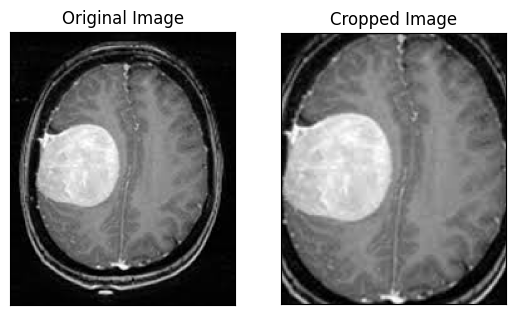

In [3]:
ex_img = cv2.imread('D://Brain-Tumor-Detection-master1//Brain-Tumor-Detection-master//yes//Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following: 
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to <i>X</i> and its label to <i>y</i>.<br>

After that, Shuffle <i>X</i> and <i>y</i>, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).<br>
Finally, Return <i>X</i> and <i>y</i>.

In [4]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

Load up the data that we augmented earlier in the Data Augmentation notebook.<br>
**Note:** the augmented data directory contains not only the new generated images but also the original images.

In [5]:
augmented_path = 'F://Brain-Tumor-Detection-master1//Brain-Tumor-Detection-master//augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


As we see, we have 2065 images. Each images has a shape of **(240, 240, 3)=(image_width, image_height, number_of_channels)**

### Plot sample images:

In [6]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

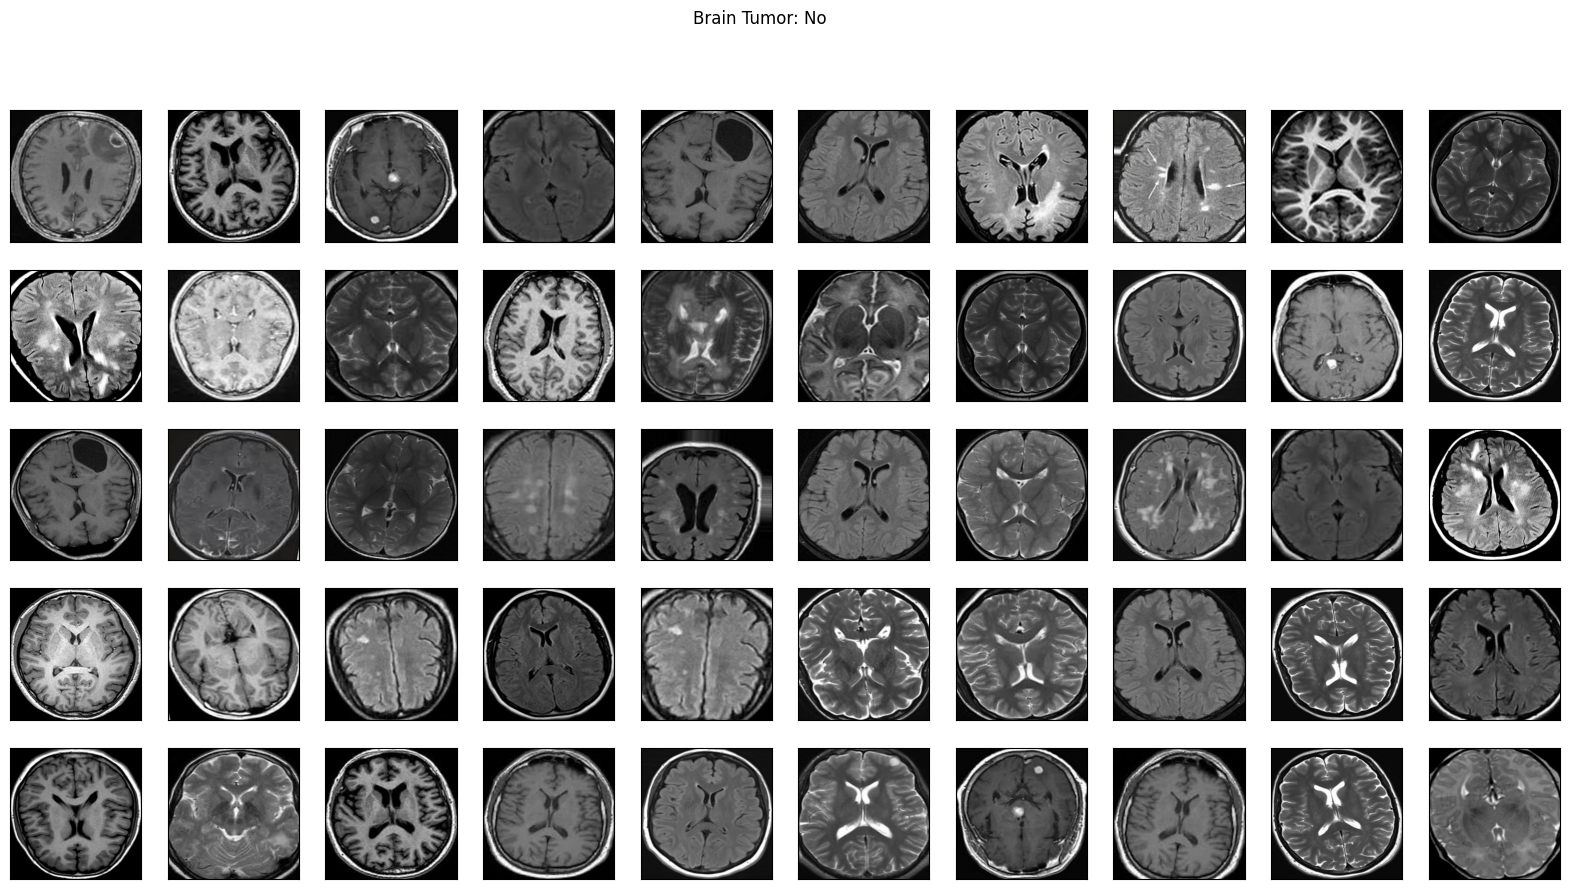

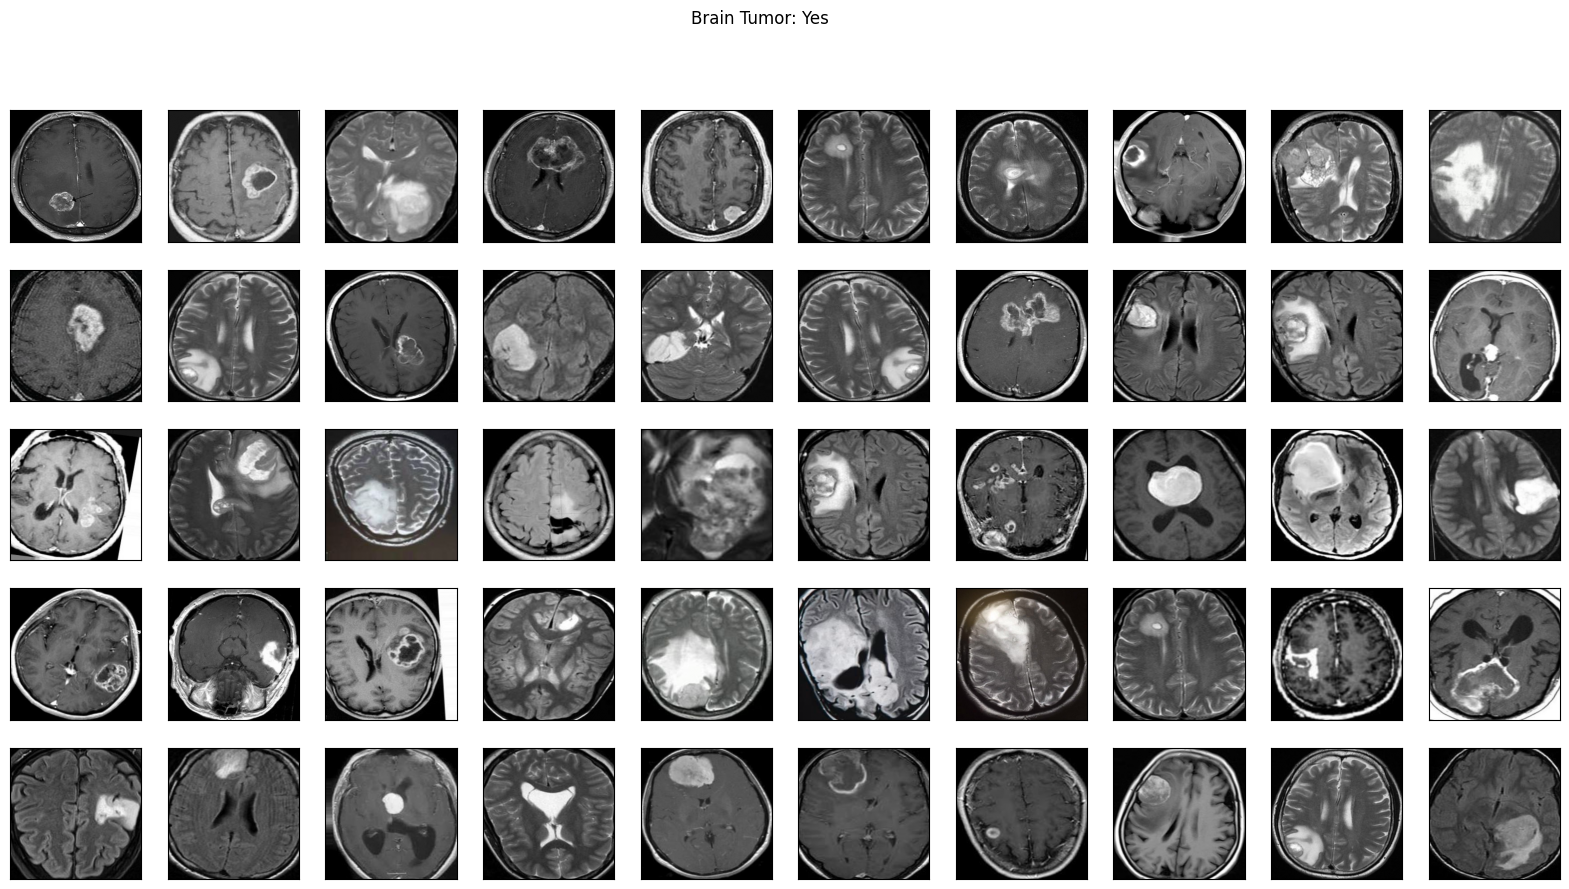

In [7]:
plot_sample_images(X, y)

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [8]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [10]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


Some helper functions:

In [11]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [12]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Build the model

Let's build a convolutional neural network model:

<img src='convnet_architecture.jpg'>

In [13]:
def resnet_block(X, filters, stage, block, s=2):
    """
    Implementation of the residual block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, stride to be used
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Define name basis
    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'
    
    # Retrieve filters
    F1, F2 = filters
    
    # Save the input value
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base+'2a', kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(3, 3), strides=(1, 1), padding='same', name=conv_name_base+'2b', kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)
    
    # Third component of main path
    X = Conv2D(filters=F2, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base+'2c', kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2c')(X)
    
    # Short path
    X_shortcut = Conv2D(filters=F2, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base+'1', kernel_initializer='glorot_uniform')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base+'1')(X_shortcut)
    
    # Add shortcut value to main path
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    return X
def resnet_block(X, filters, stage, block, s=2):
    """
    Implementation of the residual block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, stride to be used
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Define name basis
    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'
    
    # Retrieve filters
    F1, F2 = filters
    
    # Save the input value
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base+'2a', kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(3, 3), strides=(1, 1), padding='same', name=conv_name_base+'2b', kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)
    
    # Third component of main path
    X = Conv2D(filters=F2, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base+'2c', kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2c')(X)
    
    # Short path
    X_shortcut = Conv2D(filters=F2, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base+'1', kernel_initializer='glorot_uniform')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base+'1')(X_shortcut)
    
    # Add shortcut value to main path
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    return X


In [14]:
from keras.layers import Add, Conv2D, BatchNormalization, Activation, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Input, AveragePooling2D
from keras.models import Model

def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input) # shape=(?, 246, 246, 3)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X)
    X = BatchNormalization(axis=3, name='bn1')(X)
    X = Activation('relu')(X) # shape=(?, 120, 120, 64)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X) # shape=(?, 59, 59, 64)
    
    # Stage 2
    X = resnet_block(X, filters=[64, 64], stage=2, block='a', s=1)
    X = resnet_block(X, filters=[64, 64], stage=2, block='b', s=1)
    
    # Stage 3
    X = resnet_block(X, filters=[128, 128], stage=3, block='a', s=2)
    X = resnet_block(X, filters=[128, 128], stage=3, block='b', s=1)
    
    # Stage 4
    X = resnet_block(X, filters=[256, 256], stage=4, block='a', s=2)
    X = resnet_block(X, filters=[256, 256], stage=4, block='b', s=1)
    
    # Stage 5
    X = resnet_block(X, filters=[512, 512], stage=5, block='a', s=2)
    X = resnet_block(X, filters=[512, 512], stage=5, block='b', s=1)
    
    # Average pooling layer
    X = AveragePooling2D(pool_size=(2, 2), name='avg_pool')(X) # shape=(?, 1, 1, 512)
    
    # Flatten X 
    X = Flatten()(X) # shape=(?, 512)
    
    # Fully connected layer
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='BrainDetectionModel')
    
    return model
    

Define the image shape:

In [15]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [16]:
model = build_model(IMG_SHAPE)

In [17]:
model.summary()

Model: "BrainDetectionModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 246, 246, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 120, 120, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                

Compile the model:

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [20]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))

## Train the model

In [21]:
import time
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

start_time = time.time()

tensorboard = TensorBoard(log_dir="logs/{}".format(time.time()))
checkpoint = ModelCheckpoint("models/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.model", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.2f} seconds")

Epoch 1/10
46/46 [==============================] - ETA: 0s - loss: 0.8526 - accuracy: 0.6574
Epoch 1: val_accuracy improved from -inf to 0.48710, saving model to models\cnn-parameters-improvement-01-0.49.model


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.49.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.49.model\assets


46/46 [==============================] - 471s 9s/step - loss: 0.8526 - accuracy: 0.6574 - val_loss: 0.6974 - val_accuracy: 0.4871
Epoch 2/10
46/46 [==============================] - ETA: 0s - loss: 0.3361 - accuracy: 0.8720
Epoch 2: val_accuracy improved from 0.48710 to 0.54516, saving model to models\cnn-parameters-improvement-02-0.55.model


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.55.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.55.model\assets


46/46 [==============================] - 426s 9s/step - loss: 0.3361 - accuracy: 0.8720 - val_loss: 0.7111 - val_accuracy: 0.5452
Epoch 3/10
46/46 [==============================] - ETA: 0s - loss: 0.1279 - accuracy: 0.9516
Epoch 3: val_accuracy improved from 0.54516 to 0.63871, saving model to models\cnn-parameters-improvement-03-0.64.model


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.64.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.64.model\assets


46/46 [==============================] - 445s 10s/step - loss: 0.1279 - accuracy: 0.9516 - val_loss: 0.7200 - val_accuracy: 0.6387
Epoch 4/10
46/46 [==============================] - ETA: 0s - loss: 0.0608 - accuracy: 0.9799
Epoch 4: val_accuracy did not improve from 0.63871
46/46 [==============================] - 374s 8s/step - loss: 0.0608 - accuracy: 0.9799 - val_loss: 1.0277 - val_accuracy: 0.5355
Epoch 5/10
46/46 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.9827
Epoch 5: val_accuracy improved from 0.63871 to 0.65806, saving model to models\cnn-parameters-improvement-05-0.66.model


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.66.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.66.model\assets


46/46 [==============================] - 445s 10s/step - loss: 0.0422 - accuracy: 0.9827 - val_loss: 1.0418 - val_accuracy: 0.6581
Epoch 6/10
46/46 [==============================] - ETA: 0s - loss: 0.1678 - accuracy: 0.9398
Epoch 6: val_accuracy did not improve from 0.65806
46/46 [==============================] - 374s 8s/step - loss: 0.1678 - accuracy: 0.9398 - val_loss: 3.4762 - val_accuracy: 0.6000
Epoch 7/10
46/46 [==============================] - ETA: 0s - loss: 0.3013 - accuracy: 0.8830
Epoch 7: val_accuracy did not improve from 0.65806
46/46 [==============================] - 366s 8s/step - loss: 0.3013 - accuracy: 0.8830 - val_loss: 1.2600 - val_accuracy: 0.6581
Epoch 8/10
46/46 [==============================] - ETA: 0s - loss: 0.0781 - accuracy: 0.9723
Epoch 8: val_accuracy improved from 0.65806 to 0.81613, saving model to models\cnn-parameters-improvement-08-0.82.model


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.82.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.82.model\assets


46/46 [==============================] - 421s 9s/step - loss: 0.0781 - accuracy: 0.9723 - val_loss: 0.7056 - val_accuracy: 0.8161
Epoch 9/10
46/46 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9855
Epoch 9: val_accuracy improved from 0.81613 to 0.89355, saving model to models\cnn-parameters-improvement-09-0.89.model


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.89.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.89.model\assets


46/46 [==============================] - 290s 6s/step - loss: 0.0388 - accuracy: 0.9855 - val_loss: 0.4568 - val_accuracy: 0.8935
Epoch 10/10
46/46 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 0.9965
Epoch 10: val_accuracy did not improve from 0.89355
46/46 [==============================] - 186s 4s/step - loss: 0.0129 - accuracy: 0.9965 - val_loss: 0.6111 - val_accuracy: 0.8710
Execution time: 3823.59 seconds


Let's train for a few more epochs:

In [22]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Execution time: {elapsed_time:.2f} seconds")

Epoch 1/10
46/46 [==============================] - ETA: 0s - loss: 0.0423 - accuracy: 0.9841
Epoch 1: val_accuracy improved from 0.89355 to 0.92581, saving model to models\cnn-parameters-improvement-01-0.93.model


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.93.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.93.model\assets


46/46 [==============================] - 203s 4s/step - loss: 0.0423 - accuracy: 0.9841 - val_loss: 0.2139 - val_accuracy: 0.9258
Epoch 2/10
46/46 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.9965
Epoch 2: val_accuracy improved from 0.92581 to 0.96452, saving model to models\cnn-parameters-improvement-02-0.96.model


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.96.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.96.model\assets


46/46 [==============================] - 201s 4s/step - loss: 0.0128 - accuracy: 0.9965 - val_loss: 0.1284 - val_accuracy: 0.9645
Epoch 3/10
46/46 [==============================] - ETA: 0s - loss: 0.0284 - accuracy: 0.9875
Epoch 3: val_accuracy did not improve from 0.96452
46/46 [==============================] - 187s 4s/step - loss: 0.0284 - accuracy: 0.9875 - val_loss: 0.1902 - val_accuracy: 0.9258
Epoch 4/10
46/46 [==============================] - ETA: 0s - loss: 0.0986 - accuracy: 0.9612
Epoch 4: val_accuracy did not improve from 0.96452
46/46 [==============================] - 188s 4s/step - loss: 0.0986 - accuracy: 0.9612 - val_loss: 5.3204 - val_accuracy: 0.5516
Epoch 5/10
46/46 [==============================] - ETA: 0s - loss: 0.0868 - accuracy: 0.9668
Epoch 5: val_accuracy did not improve from 0.96452
46/46 [==============================] - 188s 4s/step - loss: 0.0868 - accuracy: 0.9668 - val_loss: 0.9149 - val_accuracy: 0.7935
Epoch 6/10
46/46 [===========================

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.97.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.97.model\assets


46/46 [==============================] - 202s 4s/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 0.1075 - val_accuracy: 0.9710
Epoch 9/10
46/46 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000  
Epoch 9: val_accuracy did not improve from 0.97097
46/46 [==============================] - 186s 4s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0930 - val_accuracy: 0.9677
Epoch 10/10
46/46 [==============================] - ETA: 0s - loss: 9.0882e-04 - accuracy: 0.9993
Epoch 10: val_accuracy improved from 0.97097 to 0.97419, saving model to models\cnn-parameters-improvement-10-0.97.model


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.97.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.97.model\assets


46/46 [==============================] - 199s 4s/step - loss: 9.0882e-04 - accuracy: 0.9993 - val_loss: 0.0860 - val_accuracy: 0.9742
Execution time: 3823.59 seconds


In [23]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Execution time: {elapsed_time:.2f} seconds")

Epoch 1/10
46/46 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9993
Epoch 1: val_accuracy did not improve from 0.97419
46/46 [==============================] - 190s 4s/step - loss: 0.0019 - accuracy: 0.9993 - val_loss: 0.0843 - val_accuracy: 0.9645
Epoch 2/10
46/46 [==============================] - ETA: 0s - loss: 5.1451e-04 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.97419
46/46 [==============================] - 189s 4s/step - loss: 5.1451e-04 - accuracy: 1.0000 - val_loss: 0.0772 - val_accuracy: 0.9742
Epoch 3/10
46/46 [==============================] - ETA: 0s - loss: 3.9726e-04 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.97419
46/46 [==============================] - 189s 4s/step - loss: 3.9726e-04 - accuracy: 1.0000 - val_loss: 0.0829 - val_accuracy: 0.9710
Epoch 4/10
46/46 [==============================] - ETA: 0s - loss: 1.5426e-04 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 0.97419
46/46 [===

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.98.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.98.model\assets


46/46 [==============================] - 200s 4s/step - loss: 7.0582e-05 - accuracy: 1.0000 - val_loss: 0.0900 - val_accuracy: 0.9806
Execution time: 3823.59 seconds


In [24]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Execution time: {elapsed_time:.2f} seconds")

Epoch 1/3
46/46 [==============================] - ETA: 0s - loss: 3.1351e-04 - accuracy: 1.0000
Epoch 1: val_accuracy did not improve from 0.98065
46/46 [==============================] - 192s 4s/step - loss: 3.1351e-04 - accuracy: 1.0000 - val_loss: 0.1739 - val_accuracy: 0.9645
Epoch 2/3
46/46 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9965
Epoch 2: val_accuracy did not improve from 0.98065
46/46 [==============================] - 189s 4s/step - loss: 0.0051 - accuracy: 0.9965 - val_loss: 0.1821 - val_accuracy: 0.9548
Epoch 3/3
46/46 [==============================] - ETA: 0s - loss: 0.0262 - accuracy: 0.9938
Epoch 3: val_accuracy did not improve from 0.98065
46/46 [==============================] - 191s 4s/step - loss: 0.0262 - accuracy: 0.9938 - val_loss: 0.6569 - val_accuracy: 0.8710
Execution time: 3823.59 seconds


In [25]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Execution time: {elapsed_time:.2f} seconds")

Epoch 1/5
46/46 [==============================] - ETA: 0s - loss: 0.2138 - accuracy: 0.9266
Epoch 1: val_accuracy did not improve from 0.98065
46/46 [==============================] - 192s 4s/step - loss: 0.2138 - accuracy: 0.9266 - val_loss: 7.0918 - val_accuracy: 0.6581
Epoch 2/5
46/46 [==============================] - ETA: 0s - loss: 0.1220 - accuracy: 0.9529
Epoch 2: val_accuracy did not improve from 0.98065
46/46 [==============================] - 188s 4s/step - loss: 0.1220 - accuracy: 0.9529 - val_loss: 4.8252 - val_accuracy: 0.7355
Epoch 3/5
46/46 [==============================] - ETA: 0s - loss: 0.0878 - accuracy: 0.9716
Epoch 3: val_accuracy did not improve from 0.98065
46/46 [==============================] - 188s 4s/step - loss: 0.0878 - accuracy: 0.9716 - val_loss: 1.8616 - val_accuracy: 0.7226
Epoch 4/5
46/46 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9668
Epoch 4: val_accuracy did not improve from 0.98065
46/46 [===========================

In [26]:
history = model.history.history

In [27]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


## Plot Loss & Accuracy

In [28]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

**Note:** Since we trained the model using more than model.fit() function call, this made the history only contain the metric values of the epochs for the last call (which was for 5 epochs), so to plot the metric values across the whole process of trianing the model from the beginning, I had to grab the rest of the values. 

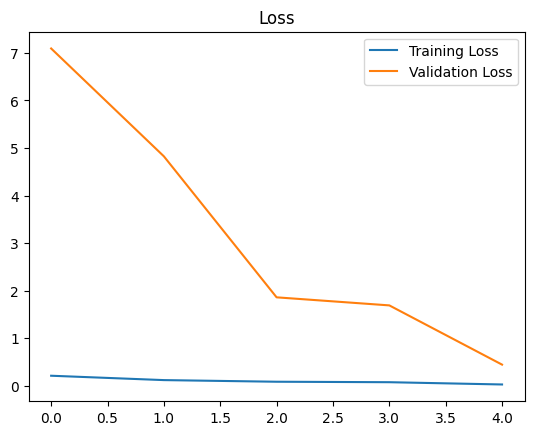

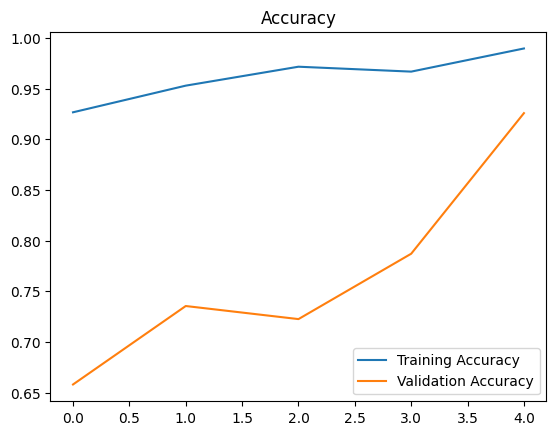

In [29]:
plot_metrics(history) 

# Results

Let's experiment with the best model (the one with the best validation accuracy):

Concretely, the model at the 10th iteration with validation accuracy of 98%

### Load the best model

In [32]:
best_model = load_model(filepath='models/cnn-parameters-improvement-10-0.98.model')

In [33]:
best_model.metrics_names

['loss', 'accuracy']

Evaluate the best model on the testing data:

In [34]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 9s 804ms/step - loss: 0.0647 - accuracy: 0.9710


### Accuracy of the best model on the testing data:

In [35]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.06465431302785873
Test Accuracy = 0.9709677696228027


### F1 score for the best model on the testing data:

In [36]:
y_test_prob = best_model.predict(X_test)

10/10 [==============================] - 9s 813ms/step


In [37]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.973293768545994


Let's also find the f1 score on the validation data:

In [38]:
y_val_prob = best_model.predict(X_val)

10/10 [==============================] - 8s 798ms/step


In [39]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.98159509202454


### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [41]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [42]:
# the whole data
data_percentage(y)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [ ]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 53.21799307958477%, number of pos examples: 769
Percentage of negative examples: 46.78200692041523%, number of neg examples: 676
Validation Data:
Number of examples: 310
Percentage of positive examples: 54.516129032258064%, number of pos examples: 169
Percentage of negative examples: 45.483870967741936%, number of neg examples: 141
Testing Data:
Number of examples: 310
Percentage of positive examples: 47.41935483870968%, number of pos examples: 147
Percentage of negative examples: 52.58064516129032%, number of neg examples: 163


As expectred, the percentage of positive examples are around 50%.